# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/alexanderdahm/Documents/GitHub/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today
#today = datetime.datetime.now(datetime.timezone.utc).replace(tzinfo=None) #New


datetime.datetime(2025, 11, 17, 20, 5, 21, 698407)

In [4]:
class Sensor:
    def __init__(self, name, row1, row2, row3, row4, row5):
        self.name = name
        self.country = "sweden"
        self.city = row2
        self.street =row3
        self.url = row1
        self.lat = float(row4.split(",")[0])
        self.lon = float(row4.split(",")[1])
        self.csv = row5

sensorList = []
# Read all lines at once
with open(f"{root_dir}/SENSORS.txt", "r", encoding="utf-8") as text_file:
    lines = [line.rstrip("\n") for line in text_file]  # keep empty lines

# Process lines in blocks of 5
for i in range(0, len(lines), 5):
    url = lines[i].strip()
    city = lines[i+1].strip()
    street = lines[i+2].strip()
    latlon = lines[i+3].strip()
    csv = lines[i+4].strip()
    sensorList.append(Sensor(f"sensor{i//5}", url, city, street, latlon, csv))
    i += 5

for sensor in sensorList:
    print(f"Processing sensor: {sensor.name} located at {sensor.street}, {sensor.city}, {sensor.country} with coordinates ({sensor.lat}, {sensor.lon}), csv path {sensor.csv}")


Processing sensor: sensor0 located at radhusgatan, ostersund, sweden with coordinates (63.17335764858055, 14.641117890305958), csv path data/östersund-rådhusgatan-air-quality.csv
Processing sensor: sensor1 located at färjemansgatan, östersund, sweden with coordinates (63.17700242430441, 14.609674671108541), csv path data/Östersund_Färjemansgatan_Sweden.csv
Processing sensor: sensor2 located at anonym, Östersund, sweden with coordinates (63.138931519854275, 14.469651548513866), csv path data/Östersund_Sweden.csv
Processing sensor: sensor3 located at Z 565, Stavre, sweden with coordinates (62.8534902632415, 15.291020082340047), csv path data/Z_565_Stavre_Sweden.csv
Processing sensor: sensor4 located at Z 811.01, Ringvattnet, sweden with coordinates (64.17830971029426, 15.431442350846709), csv path data/Z_Ringvattnet_Sweden.csv


## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
#location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
#location = json.loads(location_str)
#country=location['country']
#city=location['city']
#street=location['street']

2025-11-17 20:05:21,704 INFO: Initializing external client
2025-11-17 20:05:21,705 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 20:05:22,480 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 20:05:23,353 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286299


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

#
retrieved_model_roll3 = mr.get_model(
    name="air_quality_xgboost_model_roll3",
    version=1,
)

fv_roll3 = retrieved_model_roll3.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir_roll3 = retrieved_model_roll3.download()

2025-11-17 20:05:25,635 INFO: There is no parent information


Downloading: 0.000%|          | 0/437699 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/129322 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19541 elapsed<00:00 remaining<?

2025-11-17 20:05:32,100 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/450156 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/437699 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/128299 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/21270 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

# Roll3 model
retrieved_xgboost_model_roll3 = XGBRegressor()

retrieved_xgboost_model_roll3.load_model(saved_model_dir_roll3 + "/model_pm25_roll3.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_roll3

XGBRegressor(base_score='1.8490301E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

ostersund
radhusgatan
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.39s) 
        date  temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0 2025-11-18                -2.25                0.0            3.075841   
1 2025-11-19                -2.55                0.0            4.349896   
2 2025-11-20                -6.50                0.0            1.527351   
3 2025-11-21                -1.90                0.0            8.557102   
4 2025-11-22                 0.55                0.0            6.849467   
5 2025-11-23                -4.35                0.0            0.804985   

   wind_direction_10m_dominant       city  predicted_pm25  pm25_roll3  \
0                    20.556128  ostersund       17.703018   16.666666   
1                   335.556061  ostersund       61.017372   21.211693   
2                   135.000107  ostersund       66.833

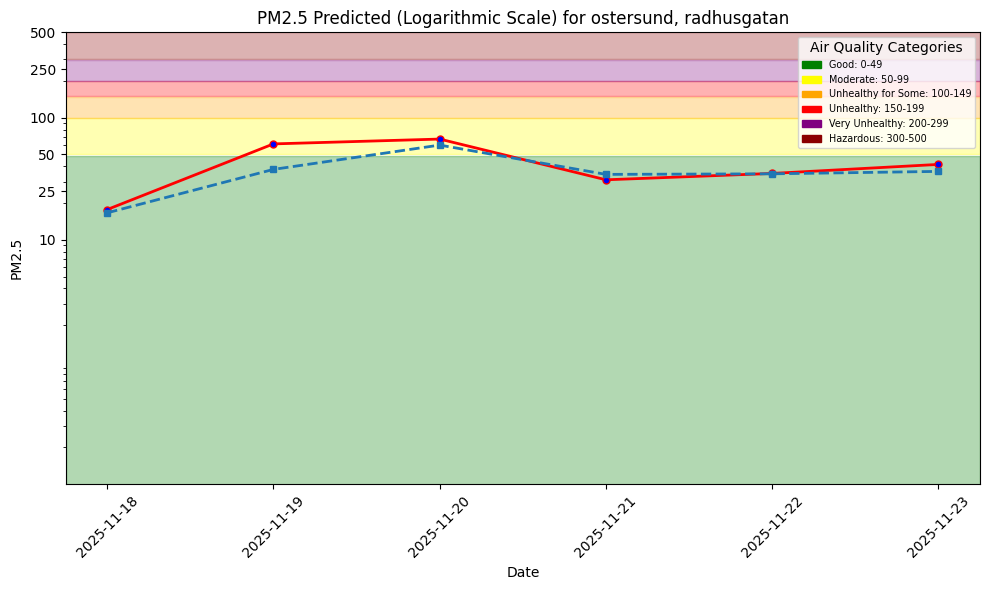

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_test_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286299/jobs/named/aq_predictions_test_1_offline_fg_materialization/executions
2025-11-17 20:05:59,572 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 20:06:02,778 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 20:08:11,954 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-17 20:08:18,444 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 20:08:18,630 INFO: Waiting for log aggregation to finish.
2025-11-17 20:08:27,240 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.42s) 
2025

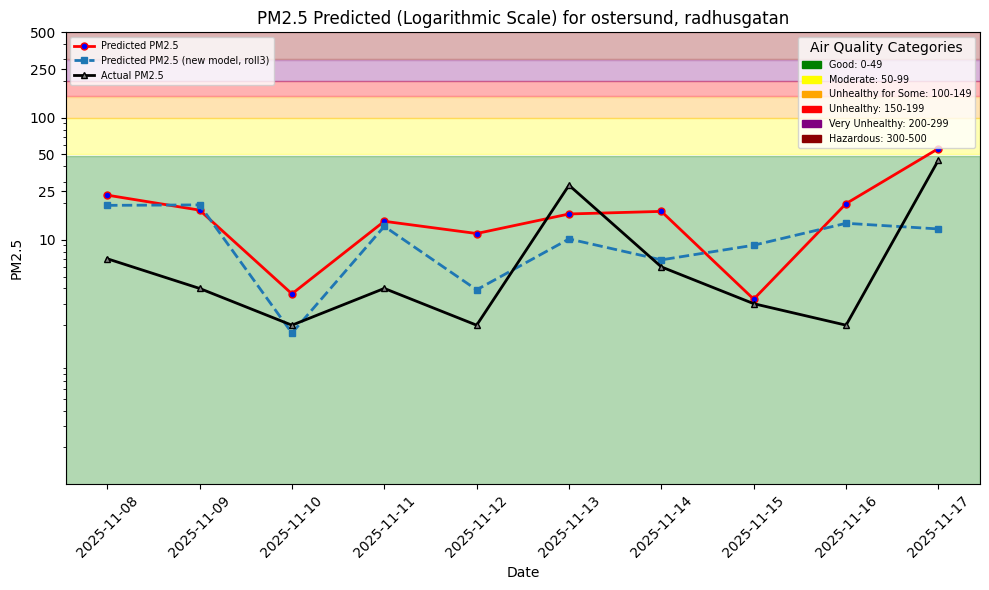

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_forecast_ostersund_…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_oster…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286299/settings/fb/path/Resources/airquality
Finished sensor: sensor0
östersund
färjemansgatan
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.67s) 
        date  temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0 2025-11-18                -1.75                0.0            3.396233   
1 2025-11-19                -2.20                0.0            5.623380   
2 2025-11-20                -5.20                0.0            3.319036   
3 2025-11-21                -1.75                0.0            9.290511   
4 2025-11-22                 0.85                0.0           10.041354   
5 2025-11-23                -3.30                0.0            2.968636   

   wind_direction_10m_dominant       city  predicted_pm25  pm25_roll3  \
0                    32.005356  östersund       24.960928    8.

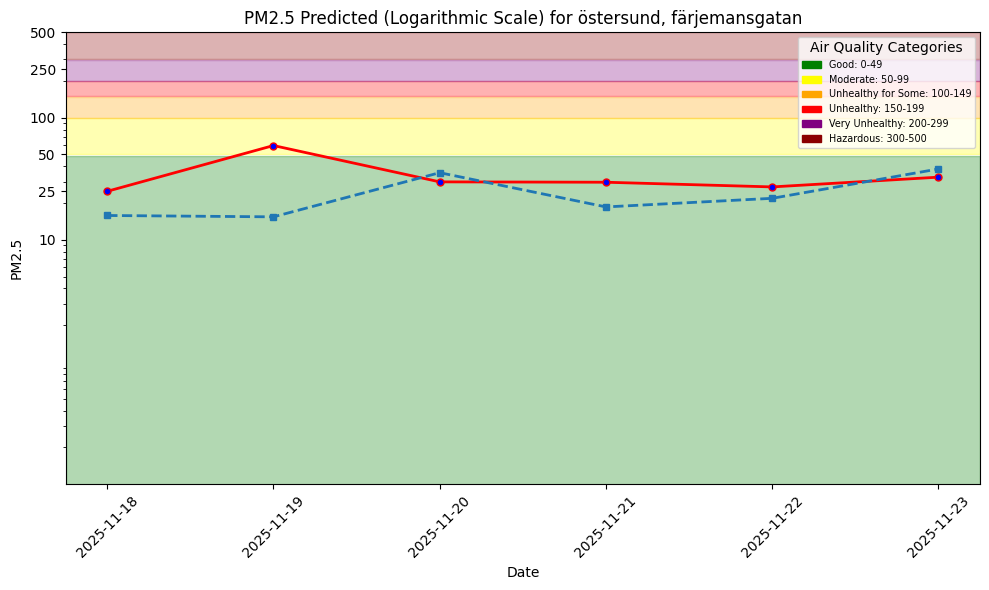

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_test_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286299/jobs/named/aq_predictions_test_1_offline_fg_materialization/executions
2025-11-17 20:09:00,400 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 20:09:03,637 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 20:11:16,206 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 20:11:16,383 INFO: Waiting for log aggregation to finish.
2025-11-17 20:11:28,488 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.51s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.69s) 
2025-11-17 20:11:33,228 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

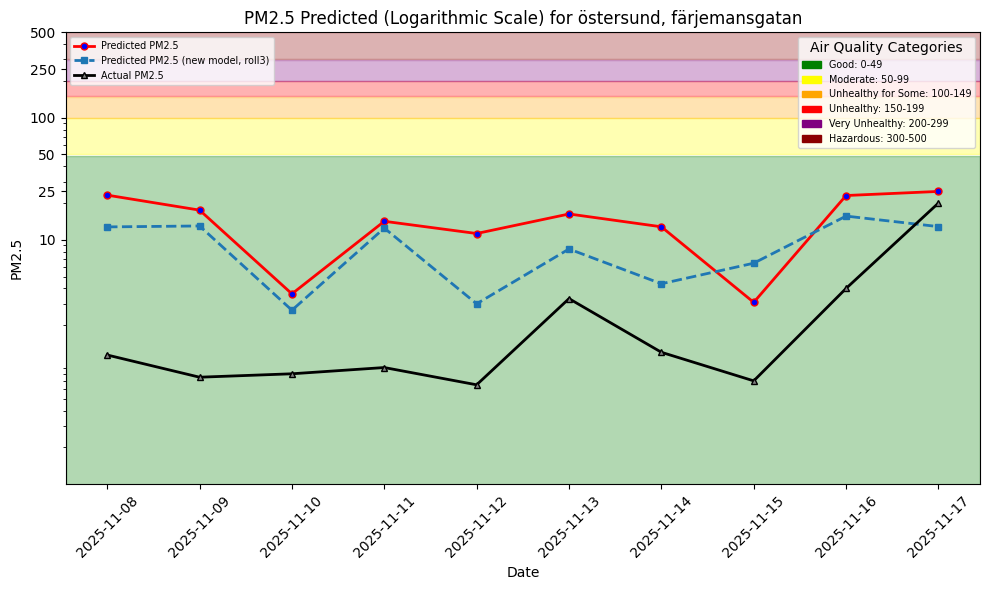

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_forecast_östersund_…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_öster…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286299/settings/fb/path/Resources/airquality
Finished sensor: sensor1
Östersund
anonym
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.20s) 
        date  temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0 2025-11-18                -1.65                0.0            3.396233   
1 2025-11-19                -2.10                0.0            5.623380   
2 2025-11-20                -5.10                0.0            3.319036   
3 2025-11-21                -1.65                0.0            9.290511   
4 2025-11-22                 0.95                0.0           10.041354   
5 2025-11-23                -3.20                0.0            2.968636   

   wind_direction_10m_dominant       city  predicted_pm25  pm25_roll3  \
0                    32.005356  Östersund       10.401987    1.200000  

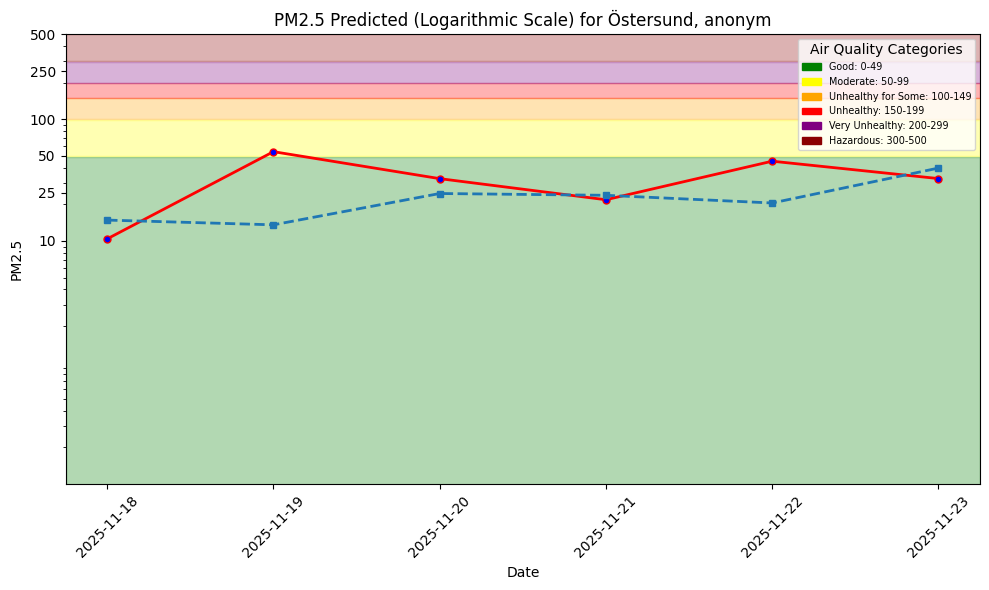

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_test_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286299/jobs/named/aq_predictions_test_1_offline_fg_materialization/executions
2025-11-17 20:12:02,686 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 20:12:09,161 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 20:13:56,181 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 20:13:56,364 INFO: Waiting for log aggregation to finish.
2025-11-17 20:14:05,283 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 
2025-11-17 20:14:09,179 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

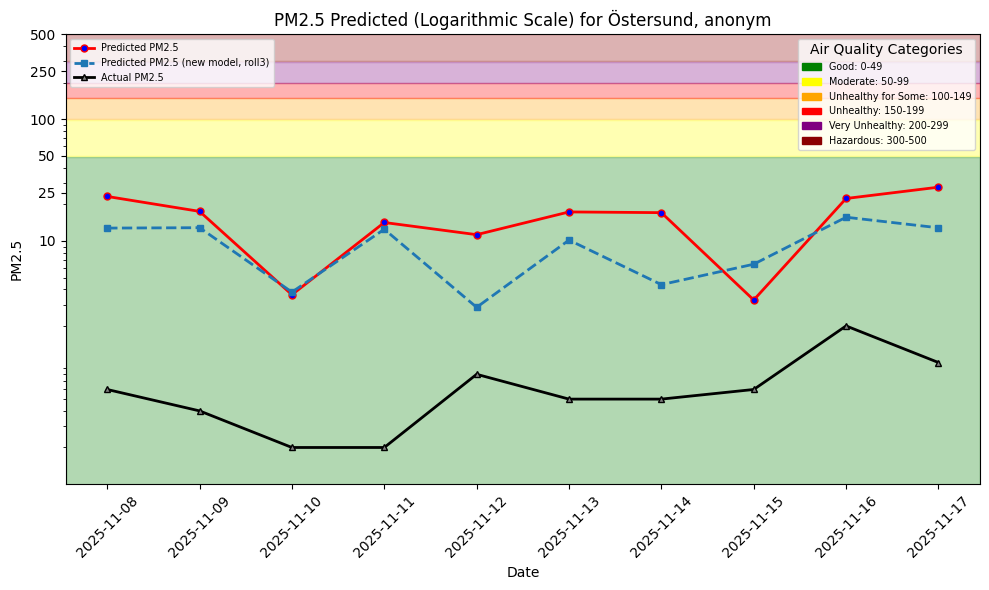

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_forecast_Östersund_…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_Öster…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286299/settings/fb/path/Resources/airquality
Finished sensor: sensor2
Stavre
Z 565
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 
        date  temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0 2025-11-18                -2.35                0.0            4.553679   
1 2025-11-19                -2.15                0.0            4.735060   
2 2025-11-20                -5.70                0.0            2.305125   
3 2025-11-21                -2.50                0.0            7.386582   
4 2025-11-22                -0.35                0.0            8.209263   
5 2025-11-23                -0.90                0.0           11.113451   

   wind_direction_10m_dominant    city  predicted_pm25  pm25_roll3  \
0                   341.564941  Stavre       63.452583    1.050000   
1       

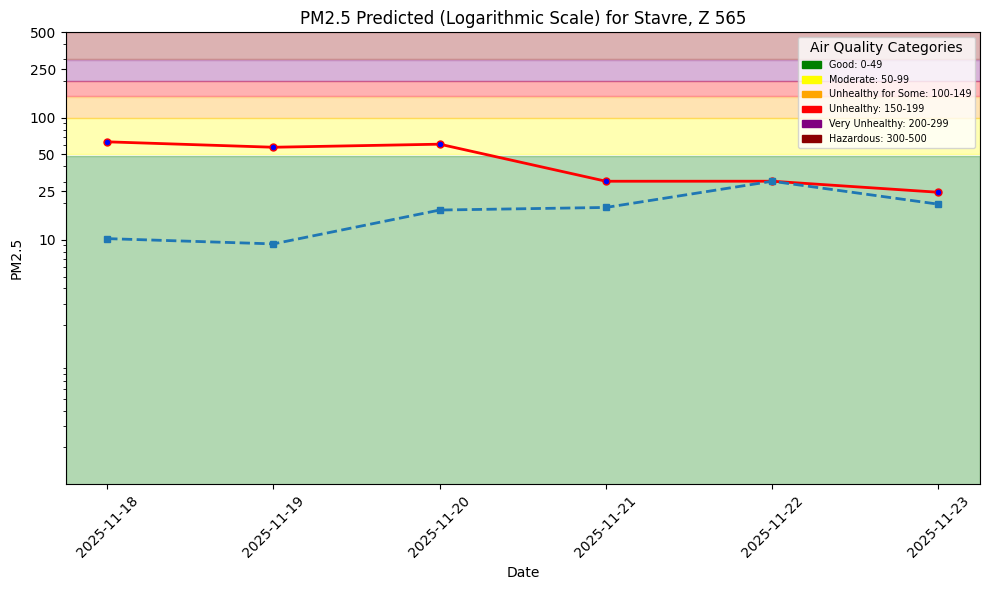

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_test_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286299/jobs/named/aq_predictions_test_1_offline_fg_materialization/executions
2025-11-17 20:14:37,448 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-17 20:14:40,669 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 20:17:06,698 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 20:17:06,850 INFO: Waiting for log aggregation to finish.
2025-11-17 20:17:15,430 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.44s) 
2025-11-17 20:17:19,155 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

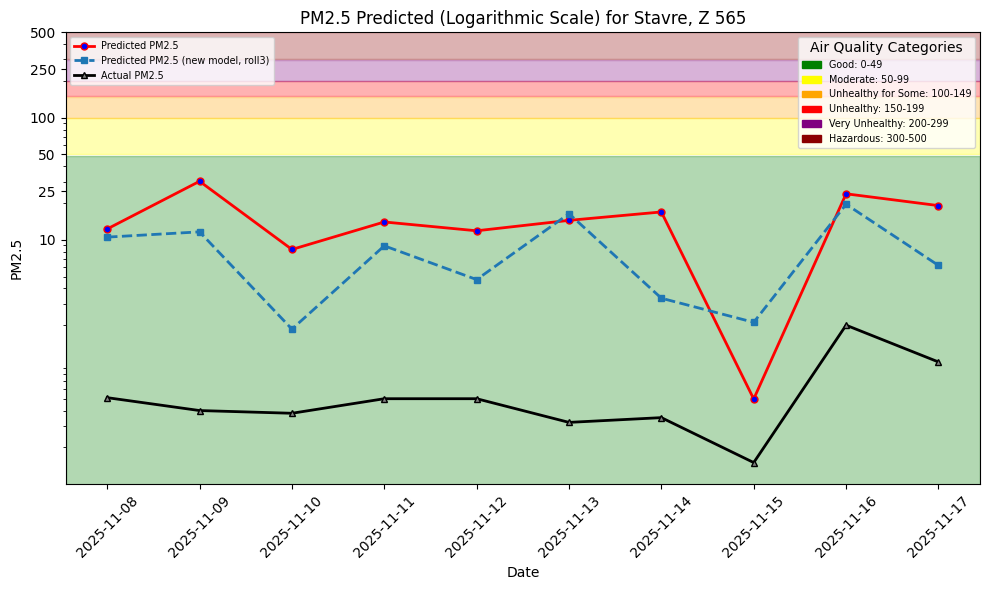

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_forecast_Stavre_Z 5…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_Stavr…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286299/settings/fb/path/Resources/airquality
Finished sensor: sensor3
Ringvattnet
Z 811.01
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.56s) 
        date  temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0 2025-11-18                -7.25                0.0            4.349896   
1 2025-11-19                -7.20                0.0            4.896530   
2 2025-11-20               -11.05                0.0            2.811690   
3 2025-11-21                -6.85                0.0            2.741678   
4 2025-11-22                -3.35                0.2            7.903619   
5 2025-11-23                -4.60                0.0            1.800000   

   wind_direction_10m_dominant         city  predicted_pm25  pm25_roll3  \
0                    24.443953  Ringvattnet       17.747559    0.

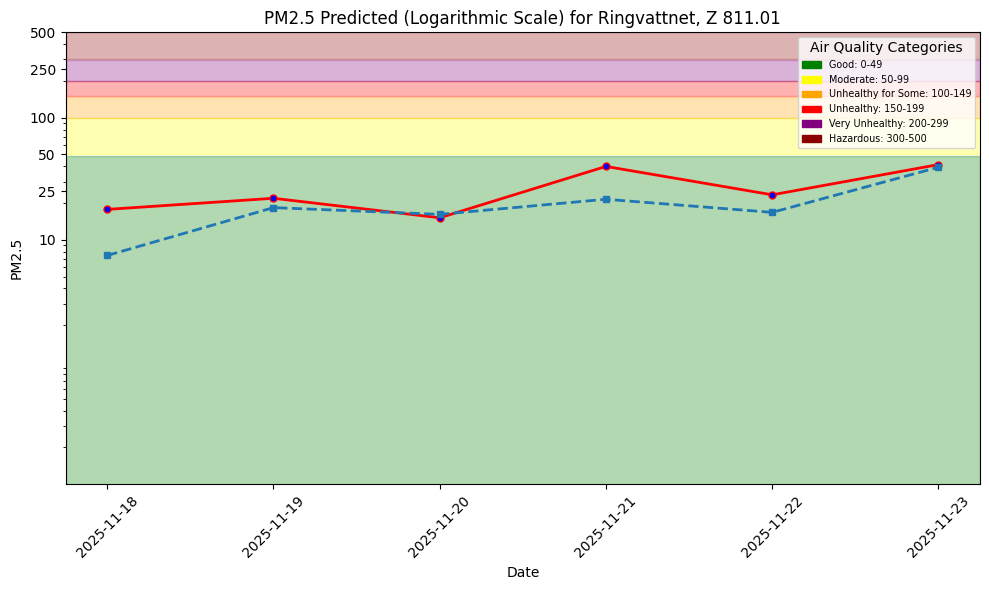

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_test_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286299/jobs/named/aq_predictions_test_1_offline_fg_materialization/executions
2025-11-17 20:17:46,456 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 20:17:49,658 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 20:19:51,741 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 20:19:51,904 INFO: Waiting for log aggregation to finish.
2025-11-17 20:20:03,891 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.87s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 
2025-11-17 20:20:08,228 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

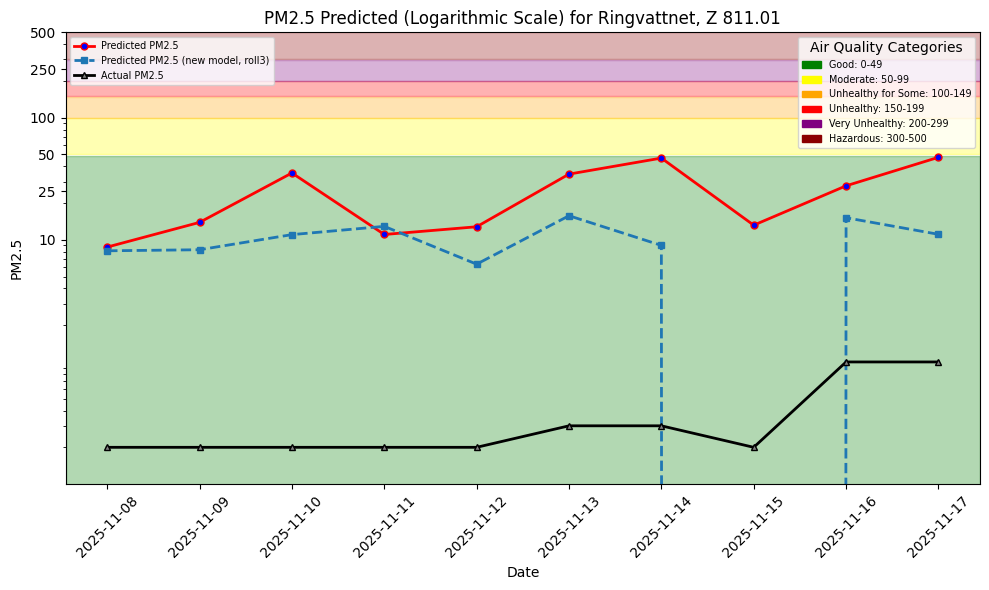

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_forecast_Ringvattne…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_Ringv…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286299/settings/fb/path/Resources/airquality
Finished sensor: sensor4


In [8]:
for sensor in sensorList:
    # Get weather data for this sensor
    print(sensor.city)
    print(sensor.street)
    
    weather_fg = fs.get_feature_group(
    name='weather_2',
    version=1,
    )
    air_quality_fg = fs.get_feature_group(
        name='air_quality_2',
        version=1,
    )
    batch_data = weather_fg.filter((weather_fg.date >= today)).read() #& (weather_fg.city == sensor.city))
    batch_data = batch_data[batch_data['city'] == sensor.city] # test
    batch_data['date'] = pd.to_datetime(batch_data['date'], utc=True).dt.tz_convert(None) #New
    batch_data = batch_data.sort_values('date').reset_index(drop=True) #New

    # Get historic air quality data to compute the roll3 value
    air_quality_hist = air_quality_fg.read()[['date', 'pm25', 'city', 'street']]
    air_quality_hist['date'] = pd.to_datetime(air_quality_hist['date'], utc=True).dt.tz_convert(None)
    
    # Get only this sensor air quality history
    air_quality_hist = air_quality_hist[(air_quality_hist['city'] == sensor.city) & (air_quality_hist['street'] == sensor.street)]
    air_quality_hist = air_quality_hist.sort_values('date').set_index('date')

    # Predictions: 

    # Original model predictions:
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])

    # Roll3 model predictions, iteratively calculating lagging mean of aq from last 3 days
    preds_new = []
    pm25_roll3_vals = []
    
    for i, row in batch_data.iterrows():
        # Get previous 3 days of air quality value
        last3 = air_quality_hist['pm25'].tail(3)
        if len(last3) < 3:
            pm25_roll3 = float('nan')
        else:
            pm25_roll3 = last3.mean()
        pm25_roll3_vals.append(pm25_roll3)
    
        # Predict new air quality value and add it so it can be used to calcualte the next roll3 mean
        X_row = pd.DataFrame([{'pm25_roll3': pm25_roll3, 'temperature_2m_mean': float(row['temperature_2m_mean']), 'precipitation_sum': float(row['precipitation_sum']), 'wind_speed_10m_max': float(row['wind_speed_10m_max']), 'wind_direction_10m_dominant': float(row['wind_direction_10m_dominant']),}])
    
        y_hat = float(retrieved_xgboost_model_roll3.predict(X_row)[0])
        preds_new.append(y_hat)
    
        # Save predicted air quality in air_quality_hist
        air_quality_hist.loc[row['date']] = y_hat
    
    batch_data['pm25_roll3'] = pm25_roll3_vals
    batch_data['predicted_pm25_new'] = preds_new
    batch_data['street'] = sensor.street
    batch_data['city'] = sensor.city
    batch_data['country'] = sensor.country
    
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data = batch_data.sort_values(by=['date'])
    print(batch_data)

    # Plot and save img for predictions
    print(sensor.street)
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{sensor.city}_{sensor.street}.png"
    plt = util.plot_air_quality_forecast(sensor.city, sensor.street, batch_data, pred_file_path)

    plt.show()

    # Insert into the monitoring feature group# Get or create feature group
    monitor_fg = fs.get_or_create_feature_group(
        name='aq_predictions_test',
        description='Air Quality prediction monitoring',
        version=1,
        primary_key=['city','street','date','days_before_forecast_day'],
        event_time="date"
    )
    
    monitor_fg.insert(batch_data, wait=True)

    # Attempt to create hindcast figure for sensor
    monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
    monitoring_df = monitoring_df[(monitoring_df['city'] == sensor.city) & (monitoring_df['street'] == sensor.street)]

    # Load real air quality outcomes for this sensor
    air_quality_df = air_quality_fg.read()
    air_quality_df['date'] = pd.to_datetime(air_quality_df['date'], utc=True).dt.tz_convert(None)
    air_quality_df = air_quality_df[(air_quality_df['city'] == sensor.city) & (air_quality_df['street'] == sensor.street)]
    
    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df =  monitoring_df[['date', 'predicted_pm25','predicted_pm25_new']]
    
    preds_df['date'] = pd.to_datetime(preds_df['date']).dt.tz_localize(None)
    outcome_df['date'] = pd.to_datetime(outcome_df['date']).dt.tz_localize(None)

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])
    
    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
        hindcast_df = util.backfill_predictions_for_monitoring_combined(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, retrieved_xgboost_model_roll3)
    print(hindcast_df)

    # Generate hindcast plot
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{sensor.city}_{sensor.street}.png"
    plt = util.plot_air_quality_forecast(sensor.city, sensor.street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()

    # Upload plots to Hopsworks
    dataset_api = project.get_dataset_api()
    str_today = today.strftime("%Y-%m-%d")
    if dataset_api.exists("Resources/airquality") == False:
        dataset_api.mkdir("Resources/airquality")
    dataset_api.upload(pred_file_path, f"Resources/airquality/{sensor.city}_{sensor.street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{sensor.city}_{sensor.street}_{str_today}", overwrite=True)
    
    proj_url = project.get_url()
    print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")
    
    print("Finished sensor:", sensor.name)

    

    
    

## 